In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Convolution2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, AveragePooling2D, UpSampling2D, Activation, Flatten, Add, ReLU
from tensorflow.keras import layers

In [2]:
# para que tf no use mucha vram

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Read dataset

In [3]:
IMAGE_SIZE = 512
BATCH_SIZE = 16
SEED = 0

In [4]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
output_shape = IMAGE_SIZE * IMAGE_SIZE * 3

In [5]:
from glob import glob

def make_dataset(path, batch_size, img_size, seed=None):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        #image = tf.image.rgb_to_grayscale(image)
        #image = tf.image.grayscale_to_rgb(image)
        image = tf.image.resize(image, [img_size, img_size])

        image = tf.cast(image, tf.float32)
        image = image / 255

        return image
    
    def parse_mask(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=1)
        #image = tf.image.rgb_to_grayscale(image)
        #image = tf.image.grayscale_to_rgb(image)
        image = tf.image.resize(image, [img_size, img_size])

        image = tf.cast(image, tf.float32)
        #image = tf.reshape(image, [img_size * img_size * 1])

        return image

    def configure_for_performance(ds):
        # Shuffle dataset every time, even if its divided by years
        ds = ds.shuffle(buffer_size=100)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        #ds = ds.prefetch(buffer_size=10)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        return ds

    path_image = "/images"
    path_mask = "/masks"

    filenames_image = [str(i) for i in glob(path + path_image + '/*')]
    filenames_mask = [str(i) for i in glob(path + path_mask + '/*')]

    filenames_image.sort()
    filenames_mask.sort()

    #print(filenames_image)
    #print(filenames_mask)

    filenames_image_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(filenames_image, dtype=tf.string))
    filenames_mask_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(filenames_mask, dtype=tf.string))

    #print(filenames_image_ds)

    images_ds = filenames_image_ds.map(lambda x: parse_image(x), num_parallel_calls=8)
    masks_ds = filenames_mask_ds.map(lambda x: parse_mask(x), num_parallel_calls=8)

    # create tensorflow dataset of images and values (train, val, test)
    images_masks_ds = tf.data.Dataset.zip((images_ds, masks_ds))
    images_masks_ds = configure_for_performance(images_masks_ds)

    return images_masks_ds, len(filenames_image)

In [6]:
train_path = 'dataset/dataset_v2/train'
val_path = 'dataset/dataset_v2/validation'
test_path = 'dataset/dataset_v2/test'

In [7]:
train_ds, len_train = make_dataset(train_path, BATCH_SIZE, IMAGE_SIZE, 0)
val_ds, len_val = make_dataset(val_path, BATCH_SIZE, IMAGE_SIZE, 0)
test_ds, len_test = make_dataset(test_path, BATCH_SIZE, IMAGE_SIZE, 0)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-15 18:18:40.831640: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 18:18:40.831773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
print(len_train * 2)
print(len_val * 2)
print(len_test * 2)

8304
456
2812


2022-11-15 18:18:41.273210: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


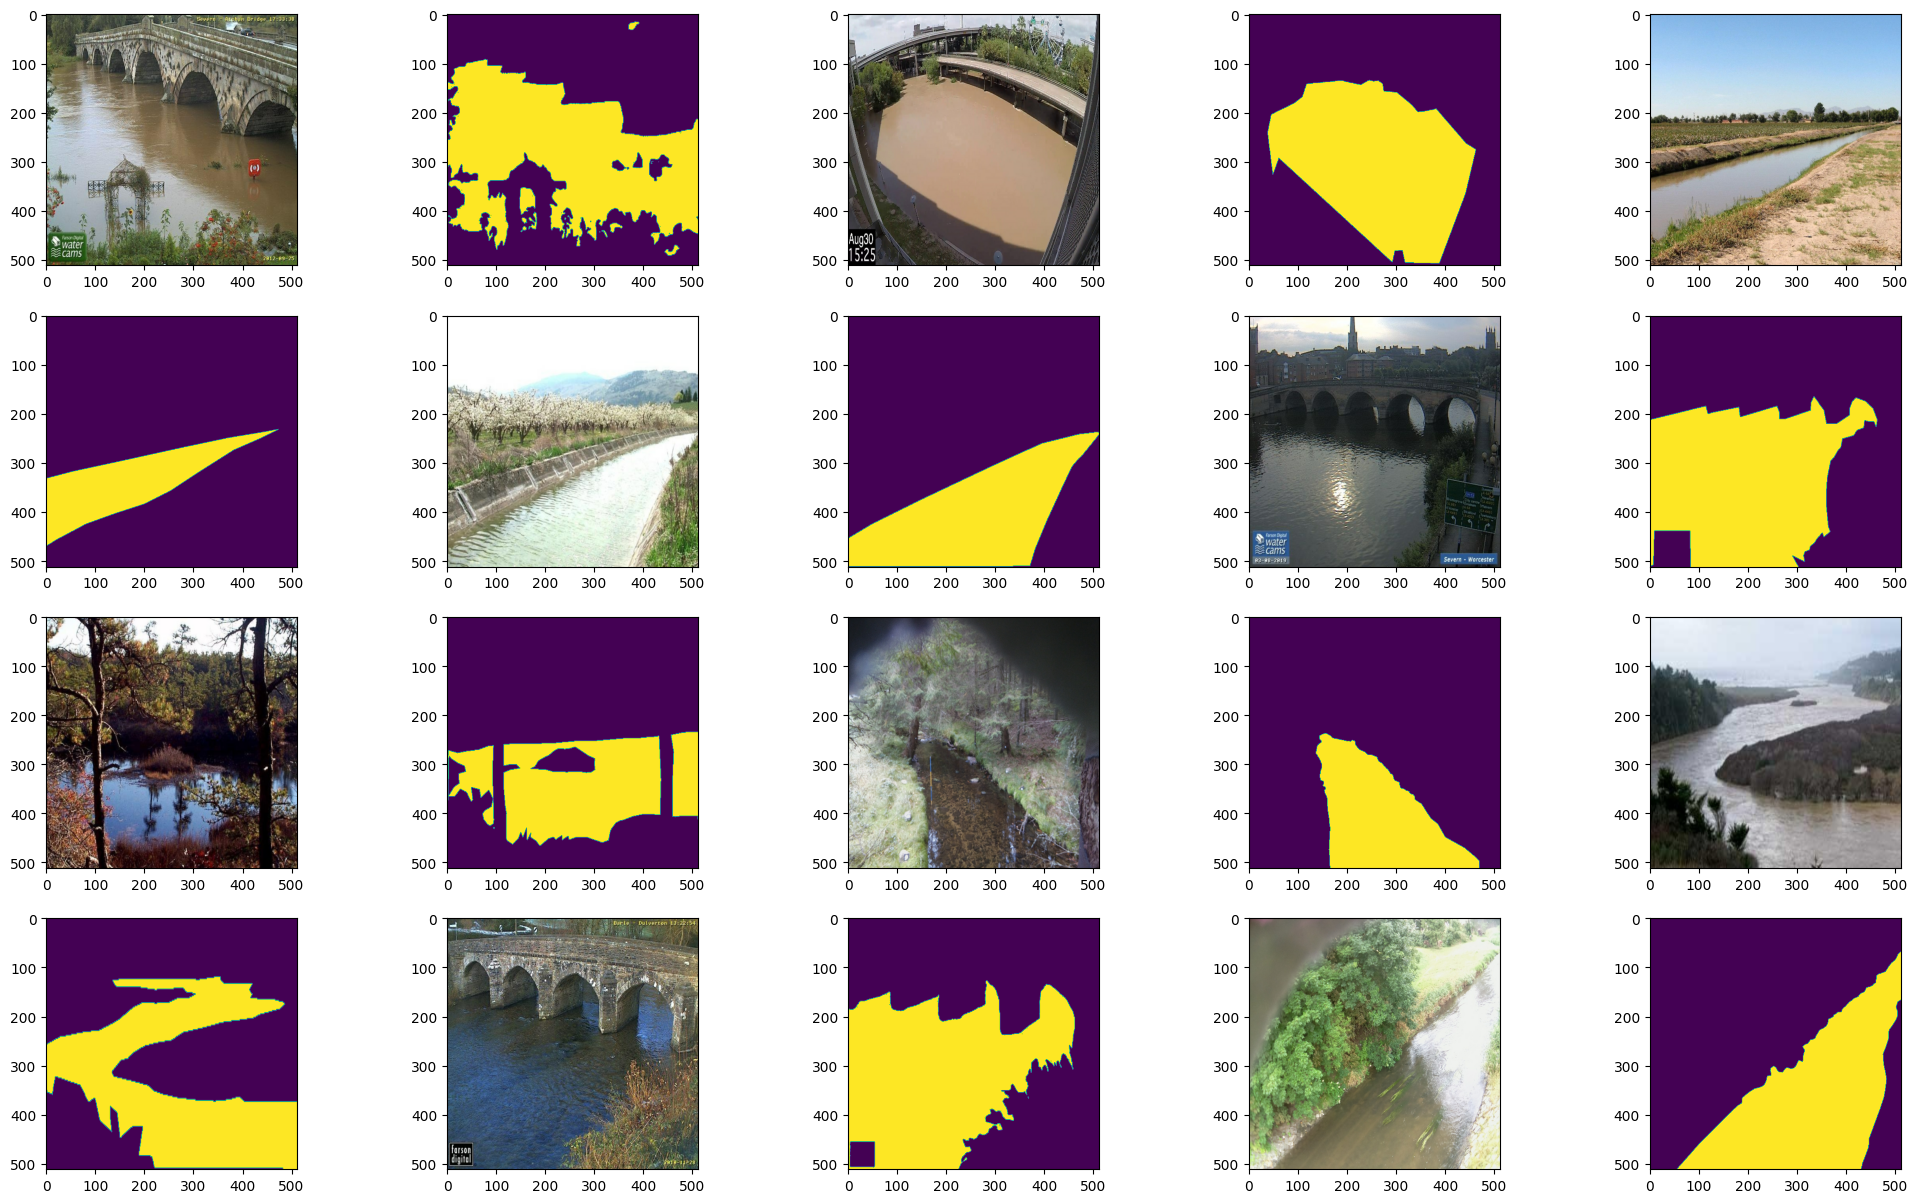

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))

for image, mask in val_ds.take(1):
    images = image[:10]
    masks = mask[:10]
    images_and_masks = []

    for i, j in zip(images, masks):
        images_and_masks.append(i)
        images_and_masks.append(j)

    for img_mask, ax in zip(images_and_masks, ax.flatten()):
        img_mask = img_mask.numpy()
        ax.imshow(img_mask)
    
    
plt.show()


## Create Model

### PSPNet

In [10]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    """base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[64,64,256],'3')
    # block_4
    base = conv_block(base,[64,64,512],'4')"""

    base = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    )
    
    for layer in base.layers:
        layer.trainable = False

    base = base(input_layer)

    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,512))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=512,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Convolution2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Convolution2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)

    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid', name='last_conv_relu')(X)
    X = Flatten(name='last_conv_flatten')(X)
    return X

### U-Net model

In [11]:
def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=(img_size, img_size) + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 6, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    #outputs = layers.Flatten()(outputs)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

In [12]:
#input_layer = tf.keras.Input(shape=input_shape, name='input')
model = get_model(IMAGE_SIZE, 1)
#model = tf.keras.Model(inputs=input_layer,outputs=output_layer)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  3488        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Train model

In [14]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_segmentation_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)

In [15]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=60, batch_size=32, steps_per_epoch=np.ceil(len_train / BATCH_SIZE), validation_steps=np.ceil(len_val / BATCH_SIZE), callbacks=[tensorboard_callback, es_callback, checkpoint_callback])

Epoch 1/60


2022-11-15 18:18:44.514986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


260/260 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8521

2022-11-15 18:27:10.080972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.73780, saving model to model_weights/20221115-181843_segmentation_best_weights.hdf5
260/260 [==============================] - 516s 2s/step - loss: 0.4268 - accuracy: 0.8521 - val_loss: 0.7378 - val_accuracy: 0.3224
Epoch 2/60
260/260 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8651
Epoch 2: val_loss did not improve from 0.73780
260/260 [==============================] - 601s 2s/step - loss: 0.3312 - accuracy: 0.8651 - val_loss: 0.8964 - val_accuracy: 0.4786
Epoch 3/60
145/260 [===============>..............] - ETA: 3:42 - loss: 0.3247 - accuracy: 0.8703

KeyboardInterrupt: 

In [ ]:
print(date_actual)

20221108-144744


In [ ]:
best_model = tf.keras.models.load_model(f'model_weights/{date_actual}_segmentation_best_weights.hdf5')

In [ ]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [ ]:
test_loss, test_accuracy = evaluate_model(best_model, test_ds, steps=np.ceil(len_test / BATCH_SIZE))

4/4 [==============================] - 1s 173ms/step - loss: 47.2374 - accuracy: 0.0000e+00


1/1 [==============================] - 0s 332ms/step


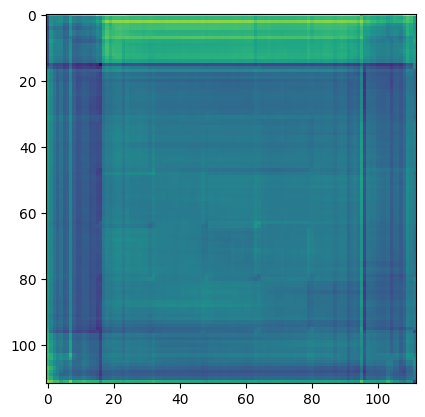

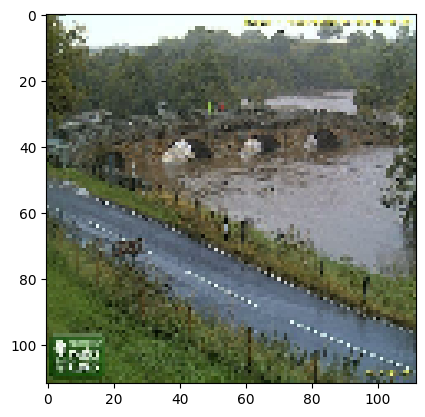

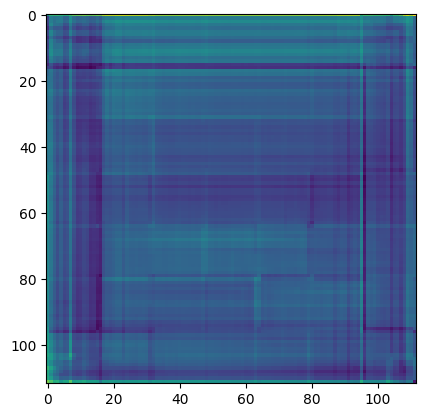

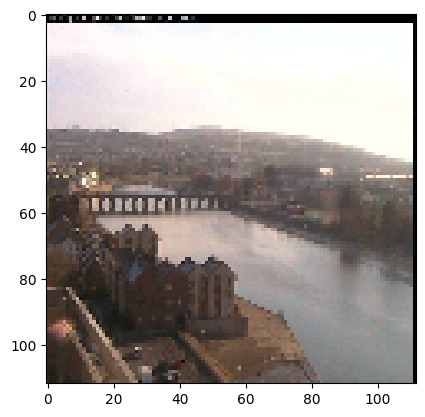

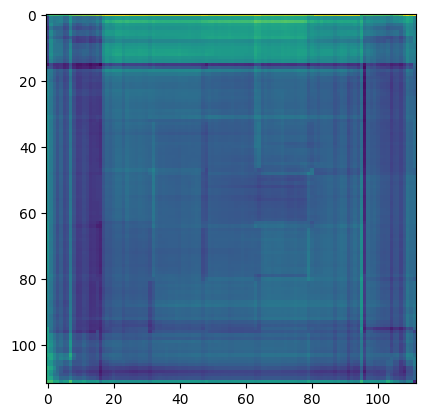

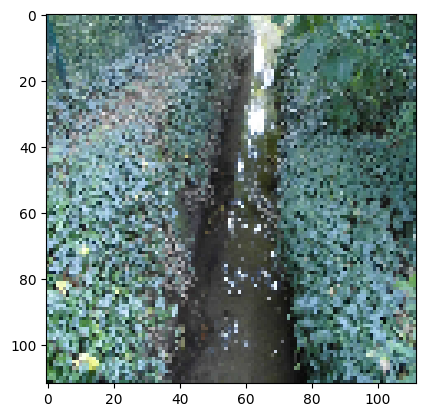

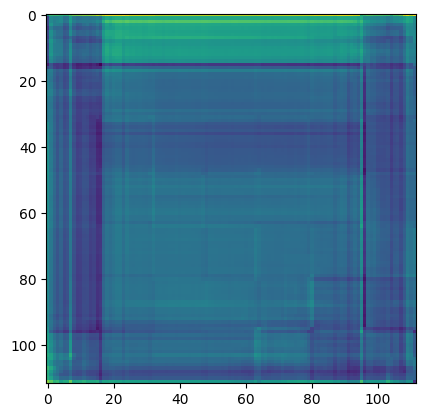

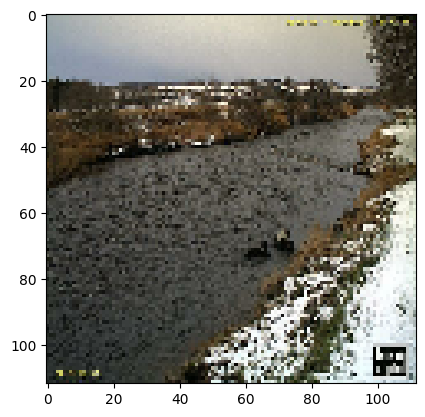

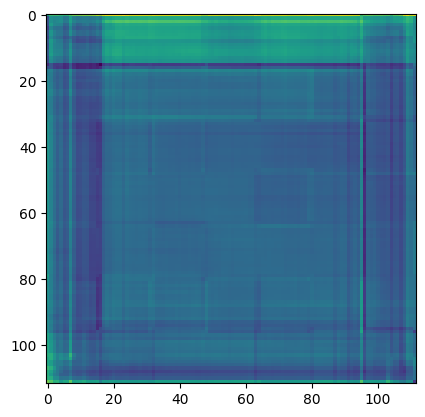

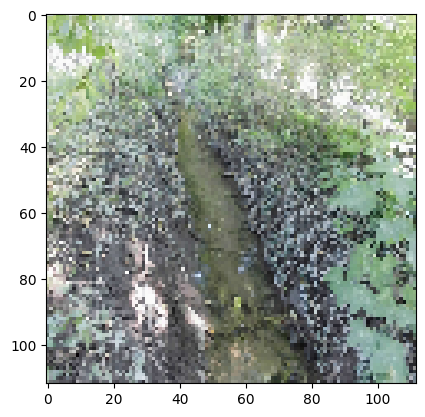

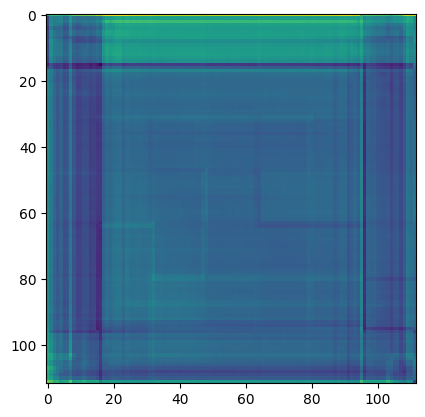

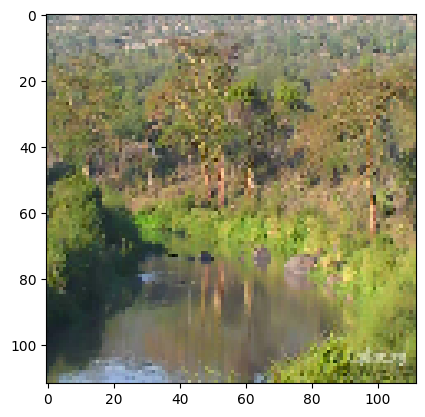

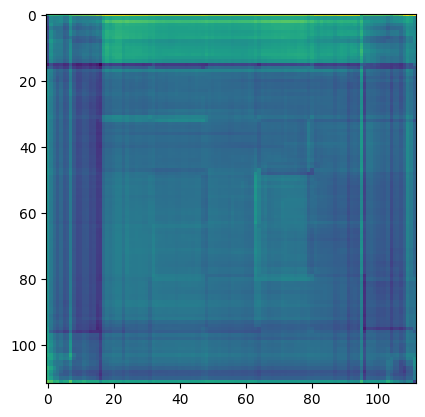

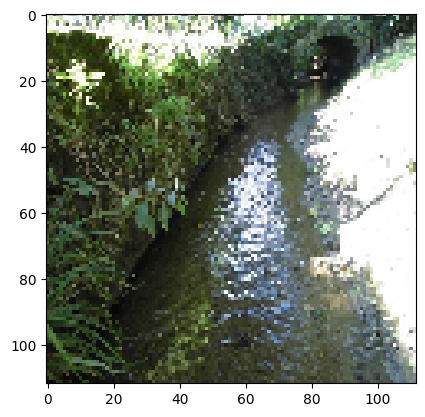

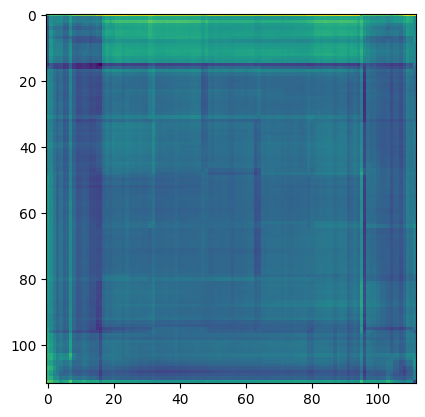

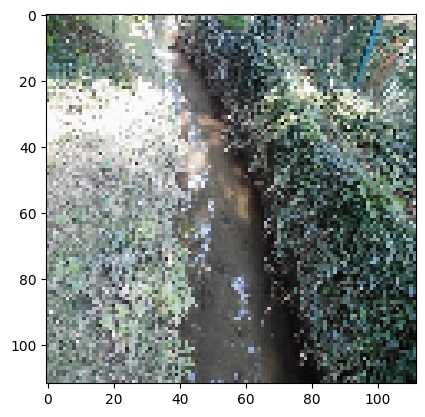

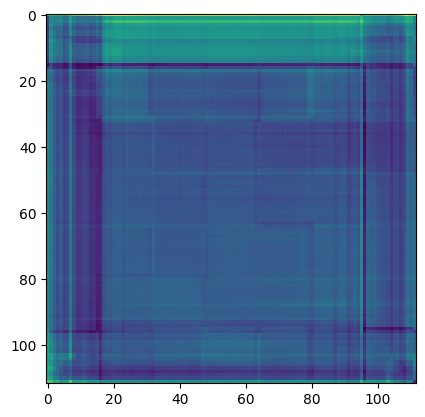

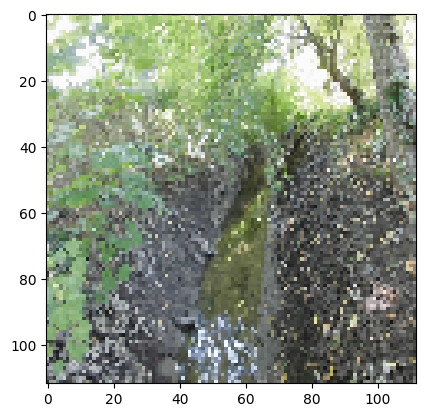

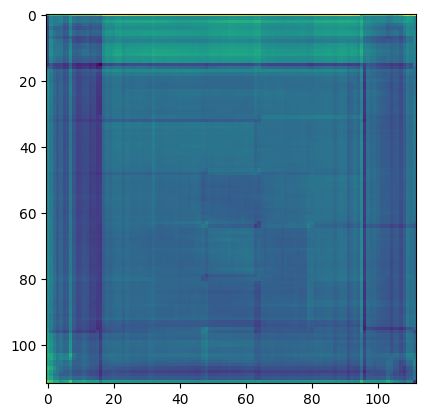

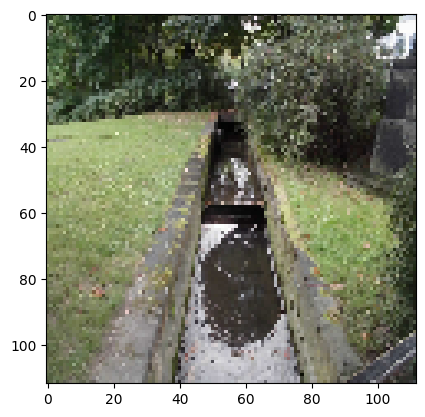

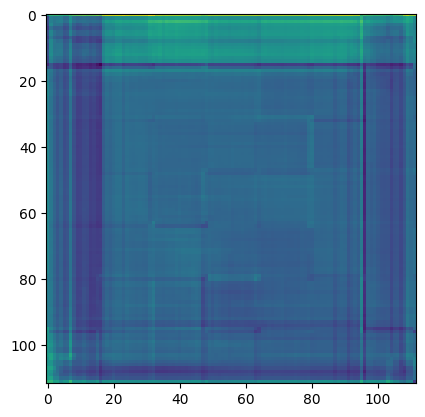

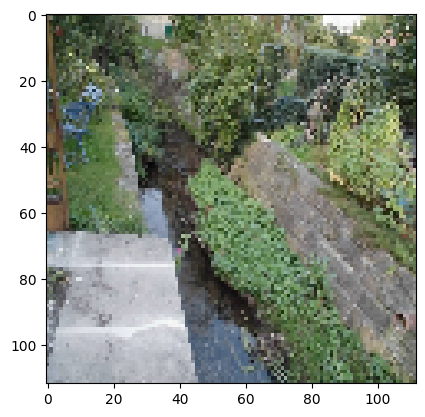

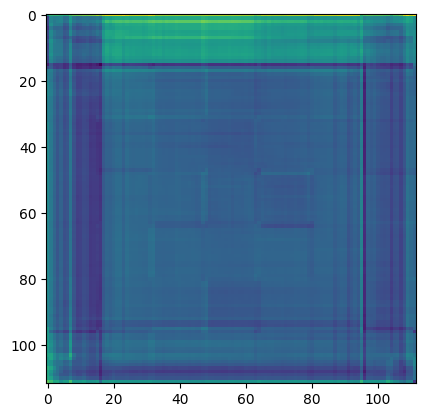

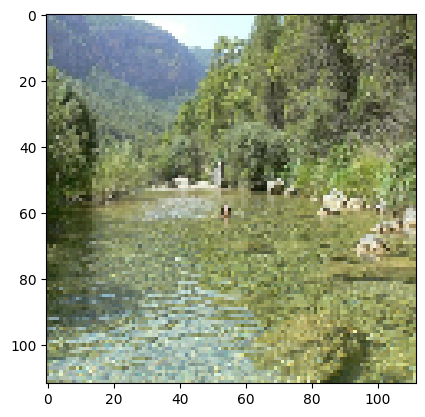

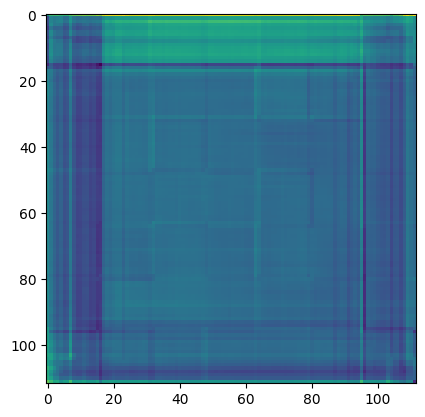

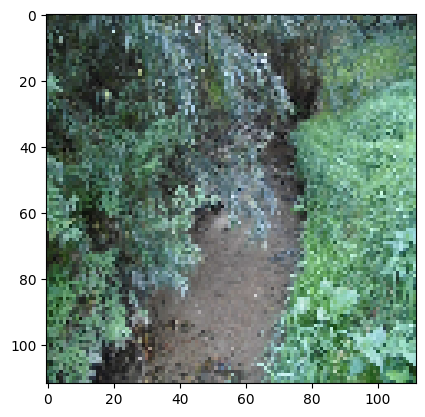

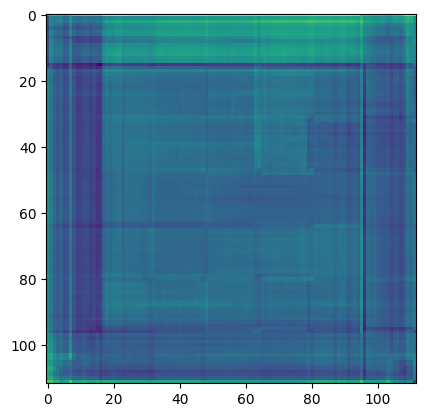

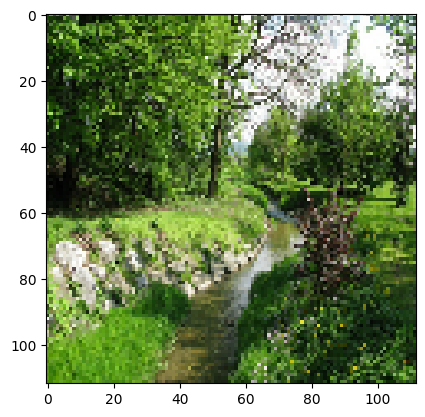

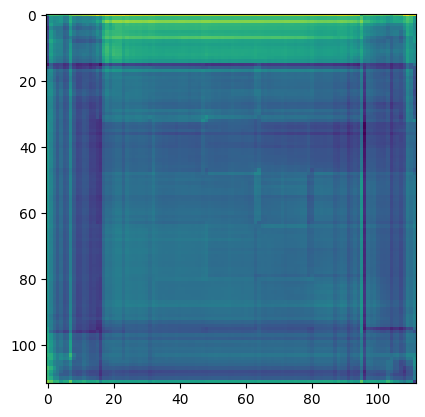

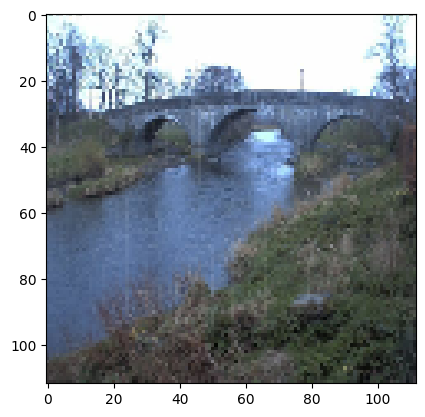

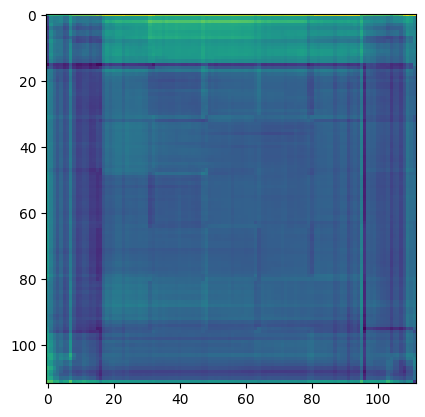

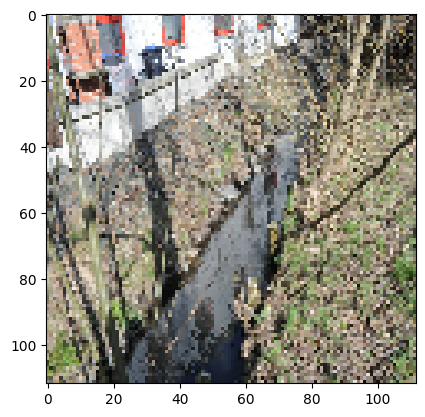

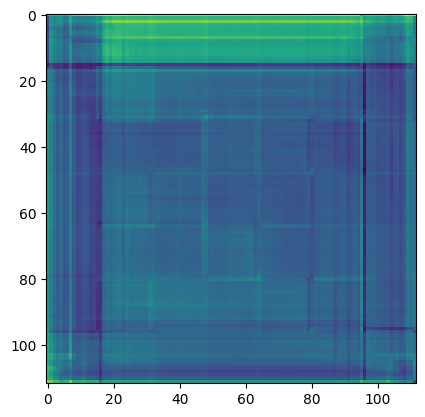

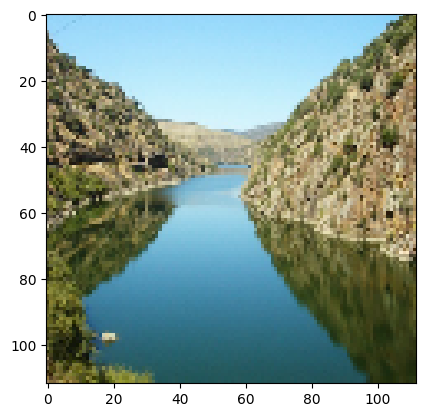

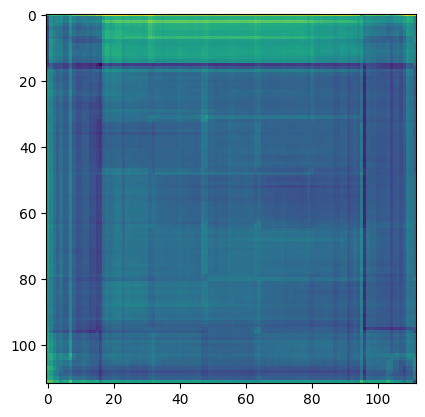

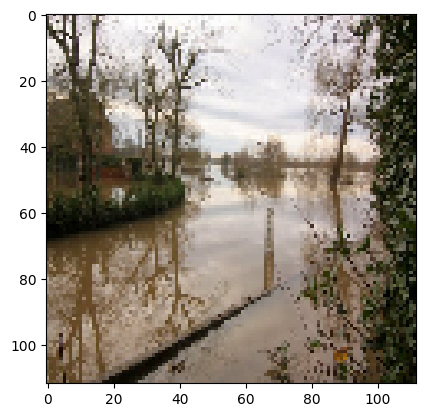

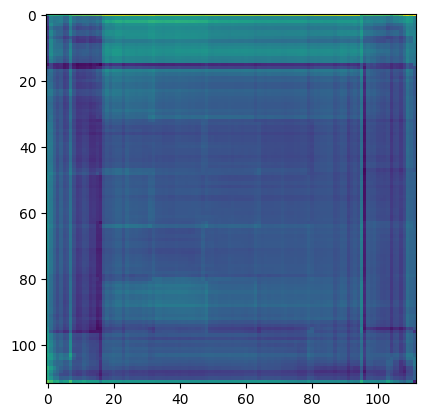

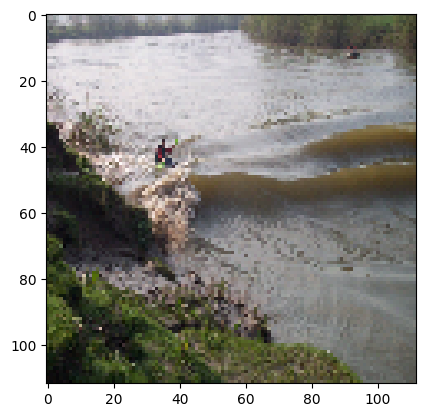

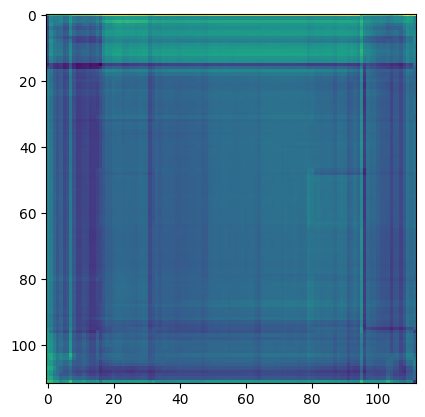

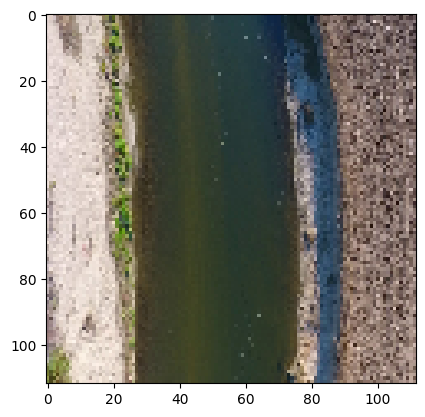

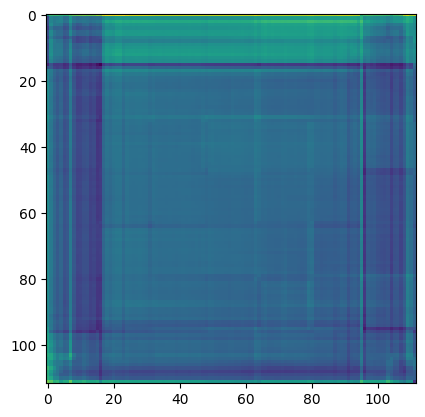

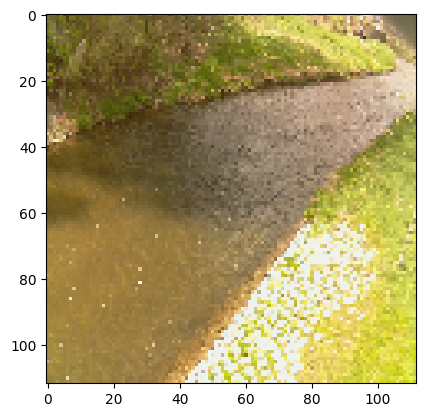

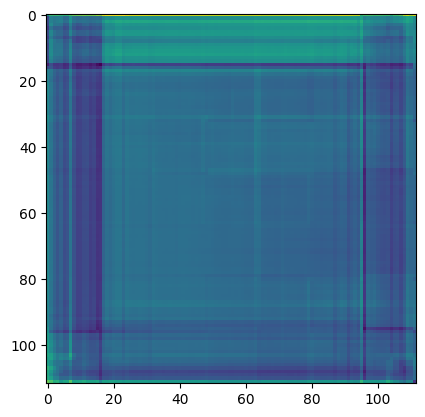

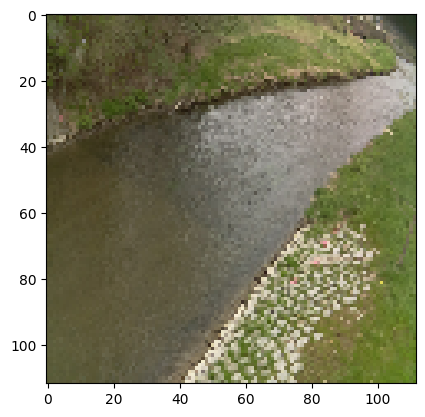

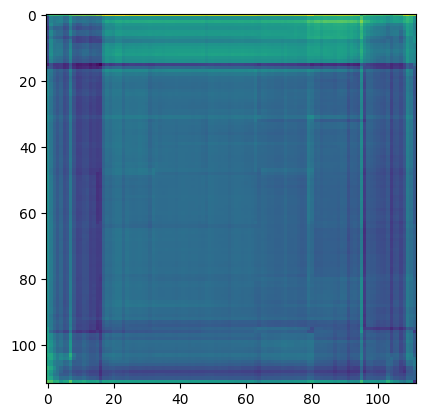

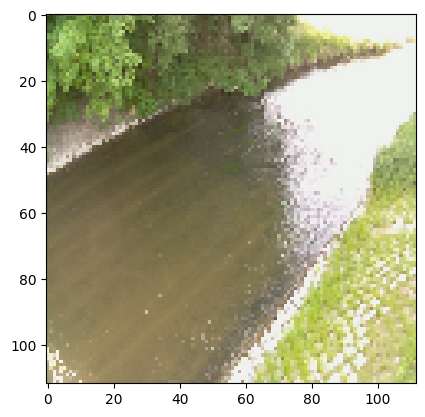

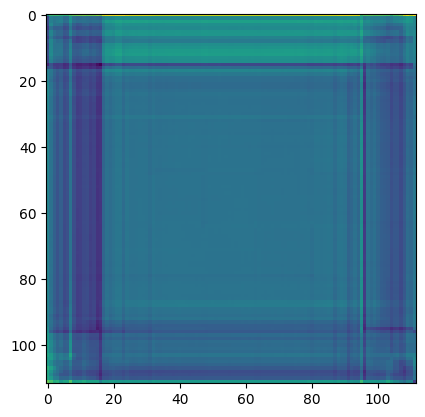

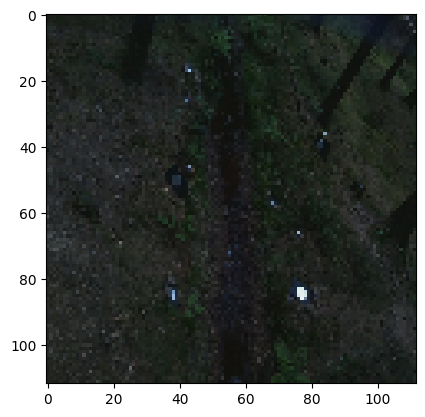

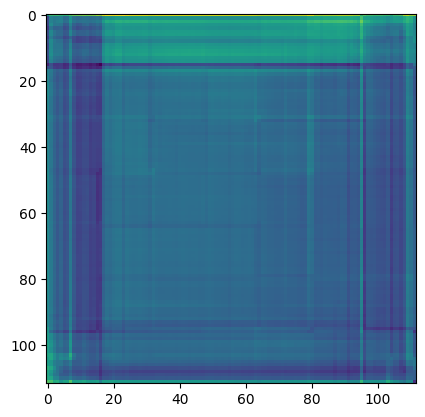

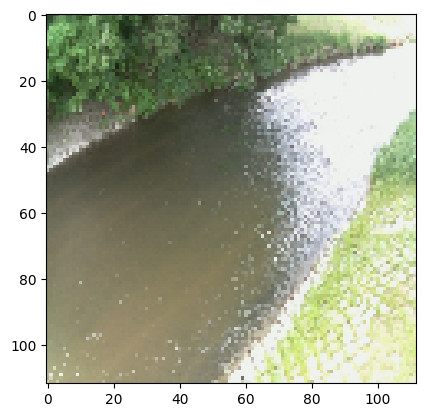

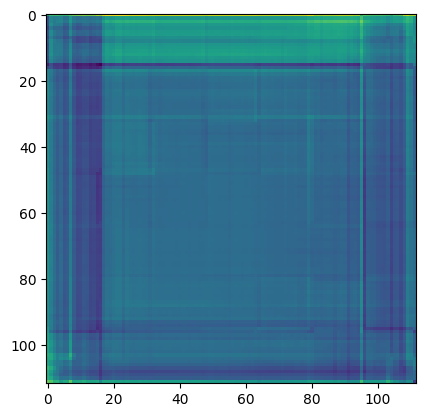

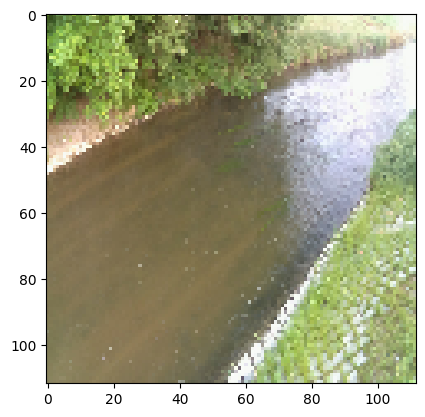

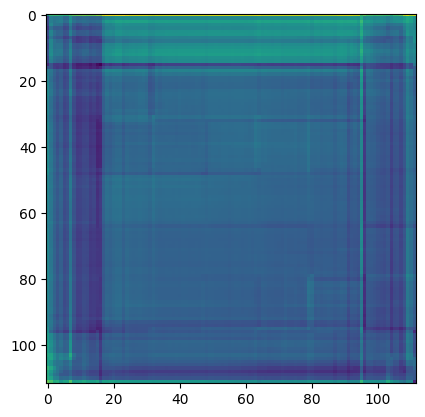

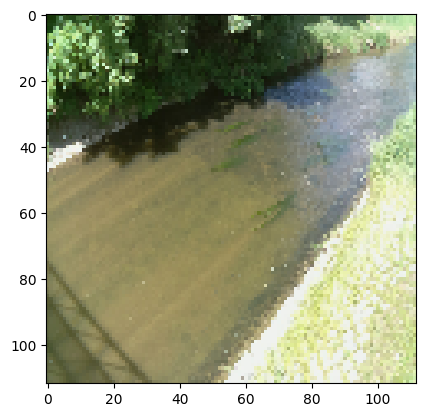

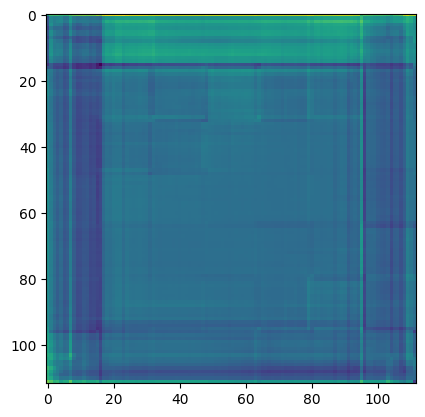

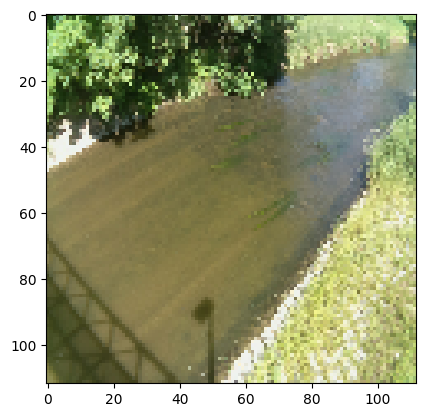

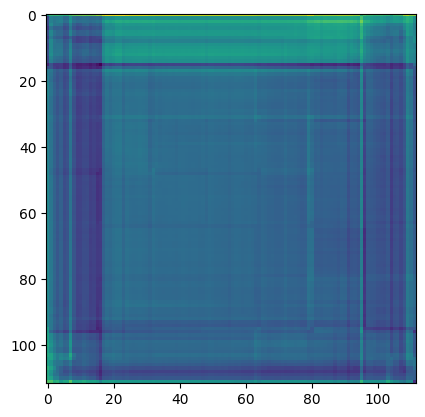

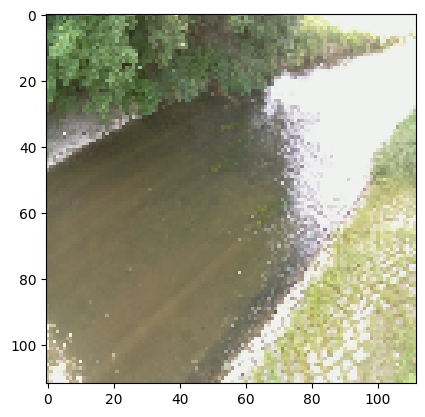

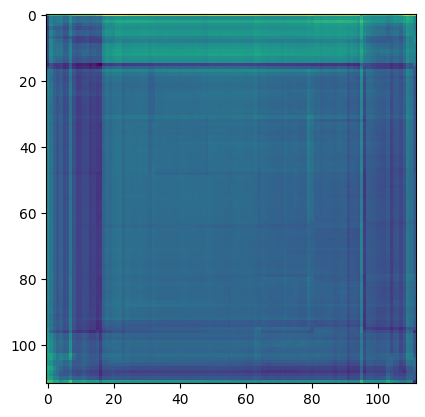

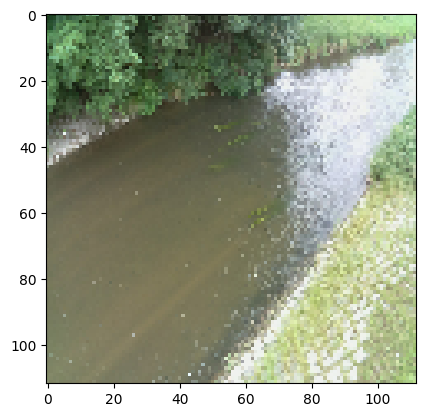

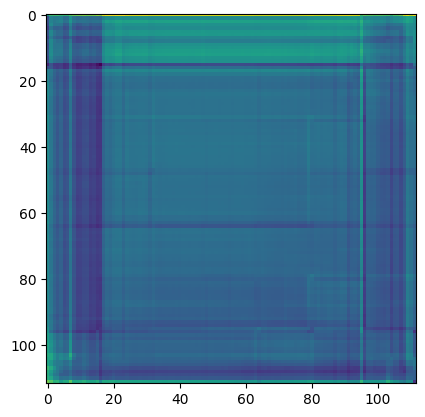

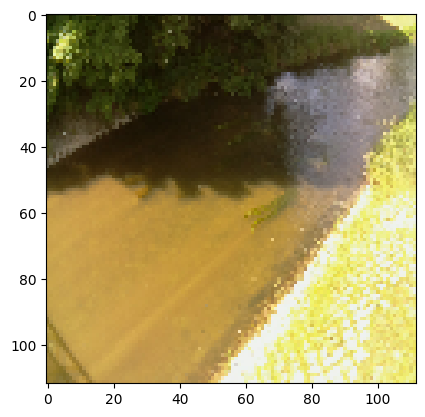

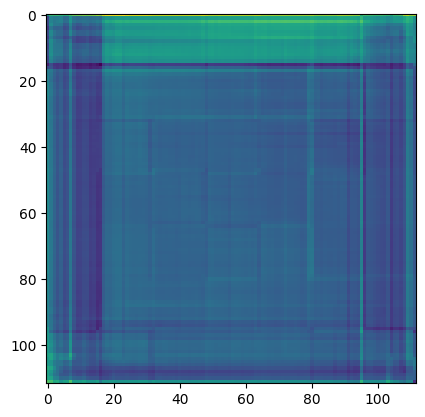

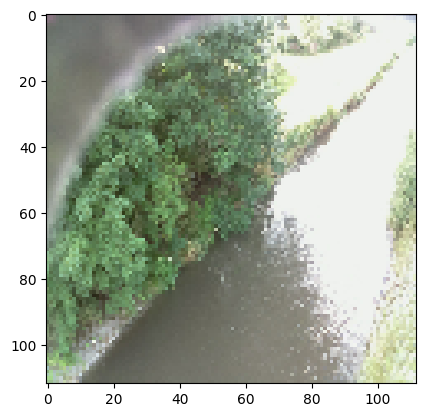

In [ ]:
for image, mask in test_ds.take(1):
    predictions = best_model.predict(x=image)
    
    for i, j in zip(predictions, image):
        j = j.numpy()
        i = np.reshape(i, (IMAGE_SIZE, IMAGE_SIZE, 1))
        
        plt.imshow(i)
        plt.show()
        plt.imshow(j)
        plt.show()
    
    plt.show()